Configuration & Path Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# 1. Dynamic Path Setup
current_dir = os.getcwd()
project_root = current_dir

# Climb up until we find 'src'
while not os.path.exists(os.path.join(project_root, 'src')):
    parent = os.path.dirname(project_root)
    if parent == project_root:
        raise FileNotFoundError("Could not find 'src'. Are you in the project folder?")
    project_root = parent

if project_root not in sys.path:
    sys.path.append(project_root)

DATA_PATH = os.path.join(project_root, 'data')
print(f"Project Root: {project_root}")
print(f"Data Path:    {DATA_PATH}")


Project Root: /home/delaunan/code/delaunan/clintrialpredict
Data Path:    /home/delaunan/code/delaunan/clintrialpredict/data


In [3]:
# 2. Import Custom Modules

from src.data_loader_tx import ClinicalTrialLoader
from src.preprocessing_XGB import get_pipeline

 Smart Data Loading (Auto-Generation)

In [4]:
CSV_PATH = os.path.join(DATA_PATH, 'project_data.csv')
FORCE_REGENERATE = False  # Set to True if you changed code in data_loader.py

if os.path.exists(CSV_PATH) and not FORCE_REGENERATE:
    print(f">>> Loading existing dataset from: {CSV_PATH}")
    df = pd.read_csv(CSV_PATH)
else:
    print(">>> File not found (or forced regeneration). Triggering ETL pipeline...")
    loader = ClinicalTrialLoader(data_path=DATA_PATH)

    # 1. Load & Clean
    df = loader.load_and_clean()

    # 2. Add Features (Hierarchy, Competition, Text)
    df = loader.add_features(df)

    # 3. Save
    loader.save(df, filename='project_data.csv')

print(f"Data Ready. Shape: {df.shape}")

>>> Loading existing dataset from: /home/delaunan/code/delaunan/clintrialpredict/data/project_data.csv
Data Ready. Shape: (67363, 136)


In [5]:
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, accuracy_score

def print_model_health(model, X_train, y_train, X_test, y_test, name="Model"):
    """
    Calculates Train vs Test metrics to diagnose overfitting.
    """
    # 1. Predict (Probs for AUC/LogLoss, Class for Acc)
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # 2. Calculate Scores
    metrics = {
        "ROC-AUC": (roc_auc_score(y_train, y_train_prob), roc_auc_score(y_test, y_test_prob)),
        "PR-AUC":  (average_precision_score(y_train, y_train_prob), average_precision_score(y_test, y_test_prob)),
        "Log Loss": (log_loss(y_train, y_train_prob), log_loss(y_test, y_test_prob)),
        "Accuracy": (accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))
    }

    # 3. Print Report
    print(f"\n📊 HEALTH CHECK: {name}")
    print(f"{'Metric':<15} | {'Train':<10} | {'Test':<10} | {'Gap (Overfit)':<15}")
    print("-" * 55)

    for metric, (train_s, test_s) in metrics.items():
        gap = train_s - test_s
        # For Log Loss, lower is better, so gap logic is reversed
        if metric == "Log Loss":
            gap = test_s - train_s

        alert = "⚠️" if gap > 0.10 else "" # Flag if gap is > 10%
        print(f"{metric:<15} | {train_s:.4f}     | {test_s:.4f}     | {gap:.4f} {alert}")
    print("-" * 55 + "\n")

Overall model

In [6]:
# ==============================================================================
# 1. TRAIN OVERALL MODEL (BASELINE - STRICT MODE)
# ==============================================================================
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

print(">>> TRAINING OVERALL MODEL (BASELINE) <<<")

# 1. Standard Split (All Phases)
df_all = df.sort_values('start_year').reset_index(drop=True)
split_idx = int(len(df_all) * 0.80)

train_df_all = df_all.iloc[:split_idx]
test_df_all = df_all.iloc[split_idx:]

target_col = 'target'
drop_cols = [target_col, 'overall_status', 'nct_id', 'why_stopped', 'start_date_type']

X_train_all = train_df_all.drop(columns=drop_cols, errors='ignore')
y_train_all = train_df_all[target_col]
X_test_all = test_df_all.drop(columns=drop_cols, errors='ignore')
y_test_all = test_df_all[target_col]

# 2. Class Weight
neg = np.sum(y_train_all == 0)
pos = np.sum(y_train_all == 1)
scale_weight_all = neg / pos

# 3. Train with "Strict" Params to reduce Overfitting
overall_model = Pipeline(steps=[
    ('preprocessor', get_pipeline()),
    ('classifier', XGBClassifier(
        n_estimators=1000,
        learning_rate=0.03,     # Slow learning
        max_depth=3,            # Shallow trees (Key to stopping overfitting)
        min_child_weight=5,     # Requires 5 samples to make a decision (ignores outliers)
        gamma=1,                # Conservative splitting
        subsample=0.7,          # Randomness
        colsample_bytree=0.7,   # Randomness
        scale_pos_weight=scale_weight_all,
        eval_metric='aucpr',
        random_state=42,
        n_jobs=-1
    ))
])

overall_model.fit(X_train_all, y_train_all)

# 4. Quick Health Check
train_auc = roc_auc_score(y_train_all, overall_model.predict_proba(X_train_all)[:, 1])
test_auc = roc_auc_score(y_test_all, overall_model.predict_proba(X_test_all)[:, 1])
print(f"Overall Train AUC: {train_auc:.4f}")
print(f"Overall Test AUC:  {test_auc:.4f}")
print(f"Gap:               {train_auc - test_auc:.4f}")

>>> TRAINING OVERALL MODEL (BASELINE) <<<
Overall Train AUC: 0.8455
Overall Test AUC:  0.7065
Gap:               0.1390


phase specific

In [11]:
# ==============================================================================
# 2. TRAIN "SAFETY vs. EFFICACY" MODELS (The Hybrid Strategy)
# ==============================================================================
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import numpy as np

# --- NEW GROUPING LOGIC ---
# Group 1: Safety (Phase 1)
# Group 2: Efficacy (Phase 2 + Phase 3)
model_groups = {
    "Safety (Phase 1)": [1],
    "Efficacy (Phase 2 + 3)": [2, 3]
}

phase_store = {}

print(f"{'GROUP':<25} | {'N_TRAIN':<8} | {'N_TEST':<8} | {'GROUP AUC':<12} | {'OVERALL AUC':<12} | {'WINNER':<10}")
print("-" * 95)

for group_name, phase_list in model_groups.items():

    # --- A. Filter Data for this GROUP ---
    # We select rows where phase_ordinal is in the list [1] or [2, 3]
    df_group = df[df['phase_ordinal'].isin(phase_list)].copy()
    df_group = df_group.sort_values('start_year').reset_index(drop=True)

    split_idx = int(len(df_group) * 0.80)
    train_df_g = df_group.iloc[:split_idx]
    test_df_g = df_group.iloc[split_idx:]

    target_col = 'target'
    drop_cols = [target_col, 'overall_status', 'nct_id', 'why_stopped', 'start_date_type']

    X_train_g = train_df_g.drop(columns=drop_cols, errors='ignore')
    y_train_g = train_df_g[target_col]
    X_test_g = test_df_g.drop(columns=drop_cols, errors='ignore')
    y_test_g = test_df_g[target_col]

    # --- B. Train Group Model ---
    neg = np.sum(y_train_g == 0)
    pos = np.sum(y_train_g == 1)
    scale_weight_g = neg / pos if pos > 0 else 1.0

    # We can use slightly deeper trees now because we have more data in the Efficacy group
    depth = 4

    group_model = Pipeline(steps=[
        ('preprocessor', get_pipeline()),
        ('classifier', XGBClassifier(
            n_estimators=1000,
            learning_rate=0.03,
            max_depth=depth,
            min_child_weight=5,     # Robustness
            gamma=1,
            subsample=0.7,
            colsample_bytree=0.7,
            scale_pos_weight=scale_weight_g,
            eval_metric='aucpr',
            random_state=42,
            n_jobs=-1
        ))
    ])

    group_model.fit(X_train_g, y_train_g)

    # --- C. Compare Scores ---
    # 1. Group Model Score
    prob_group = group_model.predict_proba(X_test_g)[:, 1]
    auc_group = roc_auc_score(y_test_g, prob_group)

    # 2. Overall Model Score (Applied to this group's test set)
    prob_overall = overall_model.predict_proba(X_test_g)[:, 1]
    auc_overall = roc_auc_score(y_test_g, prob_overall)

    winner = "Group" if auc_group > auc_overall else "Overall"

    print(f"{group_name:<25} | {len(X_train_g):<8} | {len(X_test_g):<8} | {auc_group:.4f}       | {auc_overall:.4f}       | {winner}")

    # Store for visualization/export
    # We store it by the phase numbers so we can retrieve it later
    for p in phase_list:
        phase_store[p] = {
            'model': group_model,
            'X_test': X_test_g[X_test_g['phase_ordinal'] == p], # Filter test set for specific phase eval
            'y_test': y_test_g[X_test_g['phase_ordinal'] == p],
            'name': f"{group_name} (Subset P{p})"
        }

GROUP                     | N_TRAIN  | N_TEST   | GROUP AUC    | OVERALL AUC  | WINNER    
-----------------------------------------------------------------------------------------------
Safety (Phase 1)          | 15024    | 3757     | 0.7101       | 0.7230       | Overall
Efficacy (Phase 2 + 3)    | 38865    | 9717     | 0.6813       | 0.7056       | Overall


Decision

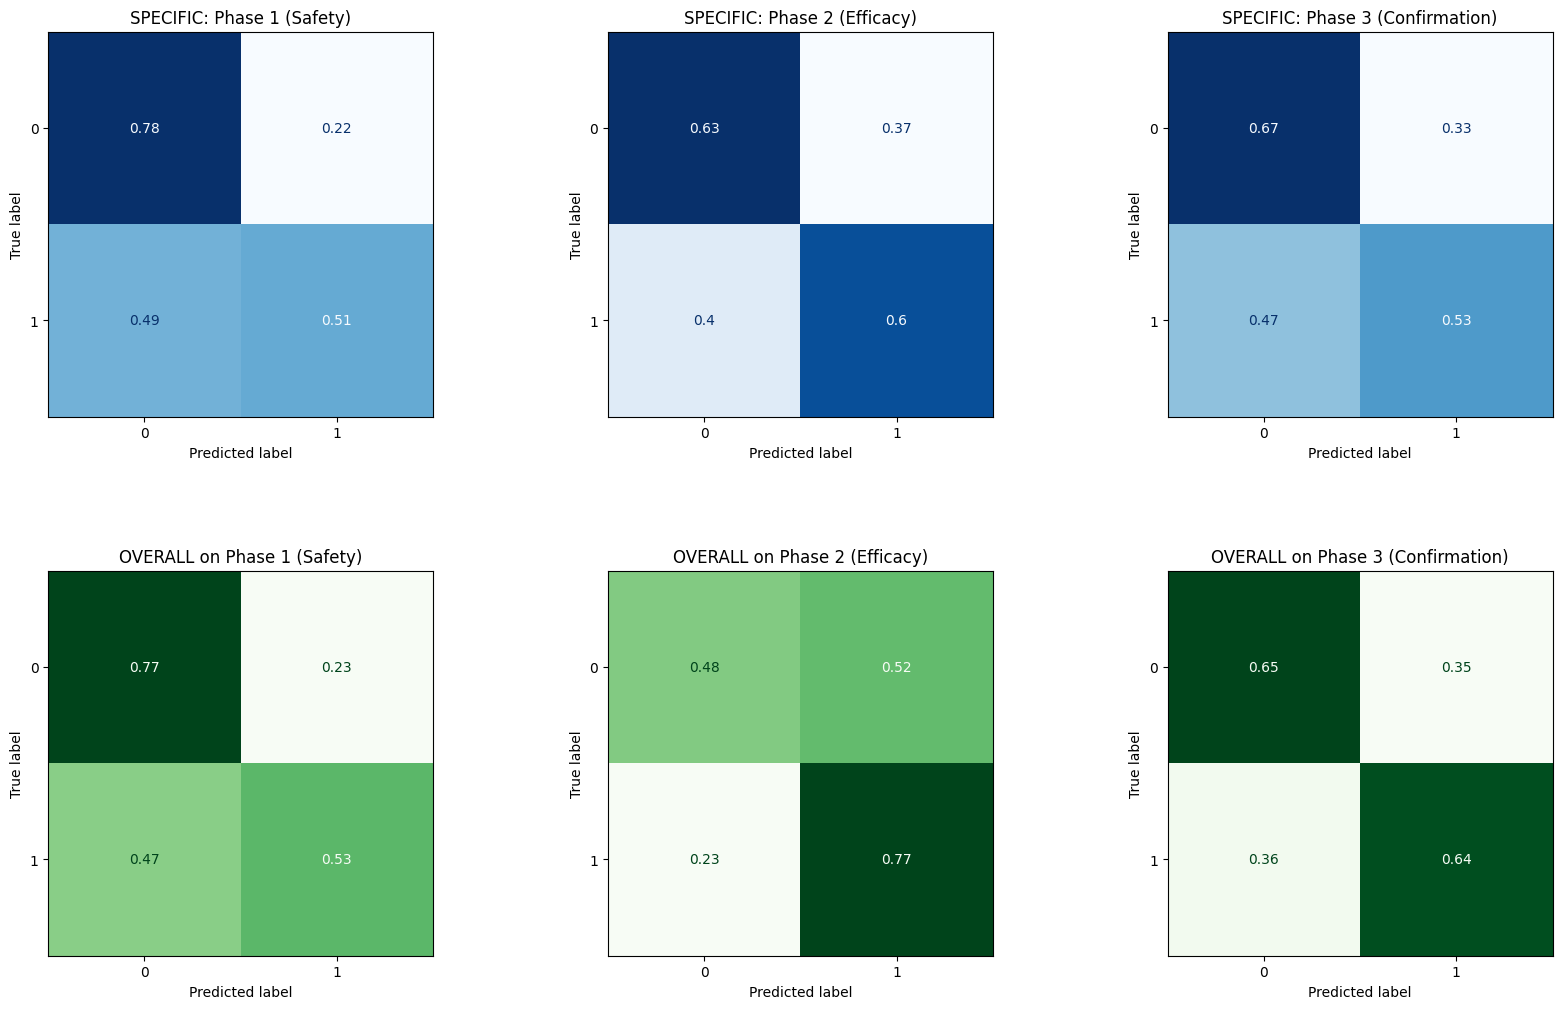

In [8]:
# ==============================================================================
# 3. VISUAL COMPARISON
# ==============================================================================
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for idx, (p_num, data) in enumerate(phase_store.items()):
    X_test = data['X_test']
    y_test = data['y_test']
    name = data['name']

    # Specific Model
    y_pred_spec = data['model'].predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_spec, normalize='true', cmap='Blues', ax=axes[0, idx], colorbar=False)
    axes[0, idx].set_title(f"SPECIFIC: {name}")

    # Overall Model
    y_pred_all = overall_model.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_all, normalize='true', cmap='Greens', ax=axes[1, idx], colorbar=False)
    axes[1, idx].set_title(f"OVERALL on {name}")

plt.show()

Evaluation

🔎 DEEP DIVE: PHASE 3 INVESTOR VIEW
--- Specific Model (Phase 3 Only) ---
              precision    recall  f1-score   support

           0       0.88      0.67      0.76      3293
           1       0.23      0.53      0.32       619

    accuracy                           0.65      3912
   macro avg       0.56      0.60      0.54      3912
weighted avg       0.78      0.65      0.69      3912

--- Overall Model (Applied to Phase 3) ---
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      3293
           1       0.26      0.64      0.37       619

    accuracy                           0.65      3912
   macro avg       0.58      0.64      0.56      3912
weighted avg       0.80      0.65      0.69      3912



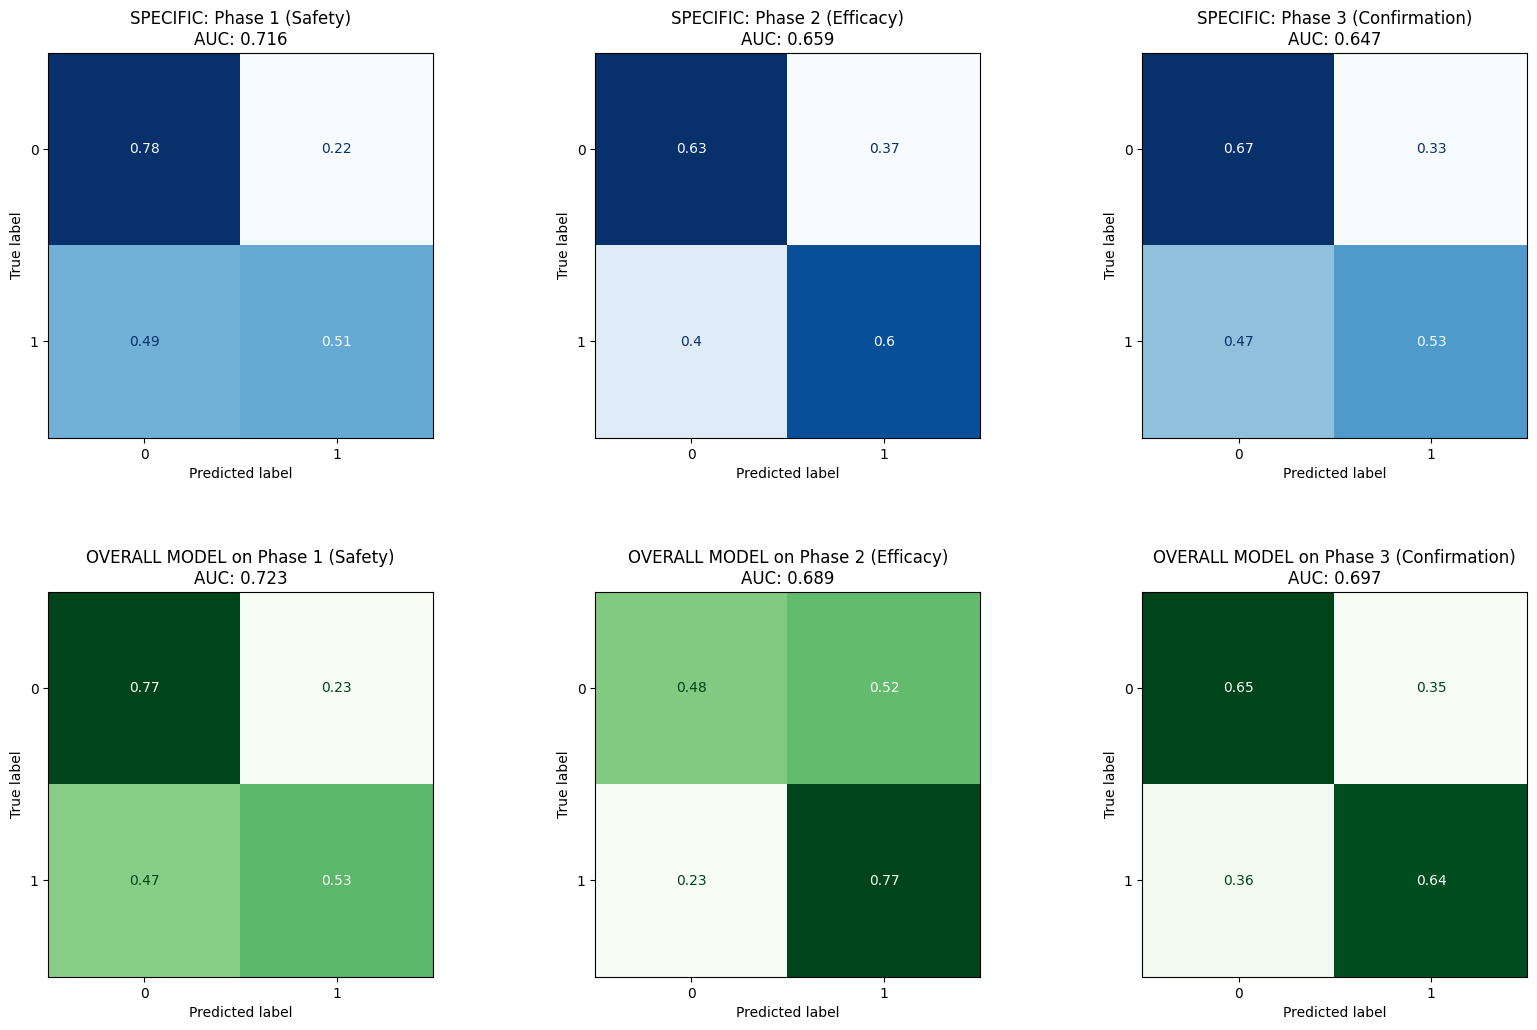

In [9]:
# ==============================================================================
# CHAMPION VS CHALLENGER: VISUAL EVALUATION
# ==============================================================================
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

# We will create a grid: 2 Rows (Specific vs Overall) x 3 Columns (Phases)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
plt.subplots_adjust(hspace=0.4)

# Row 0: Specific Models
# Row 1: Overall Model

for idx, (p_num, data) in enumerate(phase_store.items()):
    # Get Data for this phase
    X_test = data['X_test']
    y_test = data['y_test']
    name = data['name']

    # --- 1. SPECIFIC MODEL (The Challenger) ---
    spec_model = data['model']
    y_pred_spec = spec_model.predict(X_test)
    y_prob_spec = spec_model.predict_proba(X_test)[:, 1]

    roc_spec = roc_auc_score(y_test, y_prob_spec)

    # Plot Specific (Top Row)
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred_spec,
        normalize='true',
        cmap='Blues',
        ax=axes[0, idx],
        colorbar=False
    )
    axes[0, idx].set_title(f"SPECIFIC: {name}\nAUC: {roc_spec:.3f}")

    # --- 2. OVERALL MODEL (The Champion) ---
    # We use the global 'overall_model' trained in Cell A
    y_pred_all = overall_model.predict(X_test)
    y_prob_all = overall_model.predict_proba(X_test)[:, 1]

    roc_all = roc_auc_score(y_test, y_prob_all)

    # Plot Overall (Bottom Row)
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred_all,
        normalize='true',
        cmap='Greens',
        ax=axes[1, idx],
        colorbar=False
    )
    axes[1, idx].set_title(f"OVERALL MODEL on {name}\nAUC: {roc_all:.3f}")

    # --- PRINT TEXT REPORT FOR PHASE 3 ONLY (The Investor View) ---
    if p_num == 3:
        print("="*60)
        print(f"🔎 DEEP DIVE: PHASE 3 INVESTOR VIEW")
        print("="*60)
        print(f"--- Specific Model (Phase 3 Only) ---")
        print(classification_report(y_test, y_pred_spec))
        print(f"--- Overall Model (Applied to Phase 3) ---")
        print(classification_report(y_test, y_pred_all))

plt.show()

In [10]:
# ==============================================================================
# 1. TRAIN OVERALL MODEL (BASELINE - STRICT MODE)
# ==============================================================================
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

print(">>> TRAINING OVERALL MODEL (BASELINE) <<<")

# 1. Standard Split (All Phases)
df_all = df.sort_values('start_year').reset_index(drop=True)
split_idx = int(len(df_all) * 0.80)

train_df_all = df_all.iloc[:split_idx]
test_df_all = df_all.iloc[split_idx:]

target_col = 'target'
drop_cols = [target_col, 'overall_status', 'nct_id', 'why_stopped', 'start_date_type']

X_train_all = train_df_all.drop(columns=drop_cols, errors='ignore')
y_train_all = train_df_all[target_col]
X_test_all = test_df_all.drop(columns=drop_cols, errors='ignore')
y_test_all = test_df_all[target_col]

# 2. Class Weight
neg = np.sum(y_train_all == 0)
pos = np.sum(y_train_all == 1)
scale_weight_all = neg / pos

# 3. Train with "Strict" Params to reduce Overfitting
overall_model = Pipeline(steps=[
    ('preprocessor', get_pipeline()),
    ('classifier', XGBClassifier(
        n_estimators=1000,
        learning_rate=0.03,     # Slow learning
        max_depth=3,            # Shallow trees (Key to stopping overfitting)
        min_child_weight=5,     # Requires 5 samples to make a decision (ignores outliers)
        gamma=1,                # Conservative splitting
        subsample=0.7,          # Randomness
        colsample_bytree=0.7,   # Randomness
        scale_pos_weight=scale_weight_all,
        eval_metric='aucpr',
        random_state=42,
        n_jobs=-1
    ))
])

overall_model.fit(X_train_all, y_train_all)

# 4. Quick Health Check
train_auc = roc_auc_score(y_train_all, overall_model.predict_proba(X_train_all)[:, 1])
test_auc = roc_auc_score(y_test_all, overall_model.predict_proba(X_test_all)[:, 1])
print(f"Overall Train AUC: {train_auc:.4f}")
print(f"Overall Test AUC:  {test_auc:.4f}")
print(f"Gap:               {train_auc - test_auc:.4f}")

>>> TRAINING OVERALL MODEL (BASELINE) <<<
Overall Train AUC: 0.8455
Overall Test AUC:  0.7065
Gap:               0.1390
